In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
%matplotlib inline
tf.__version__

'2.2.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd 'drive/My Drive'

/content/drive/My Drive


In [ ]:
os.getcwd()

'/content/drive/My Drive'

In [ ]:
data_dir=os.path.join(os.getcwd(),'Swedish Leaf')

Splitting the Dataset into Train,Test and Validation Sets

In [ ]:
image_generator=ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [ ]:
train_dataset=image_generator.flow_from_directory(
    batch_size=64,
    directory=data_dir,
    shuffle=True,
    target_size=(128,128),
    subset='training',
    class_mode='categorical'
)

Found 4800 images belonging to 15 classes.


In [ ]:
val_dataset=image_generator.flow_from_directory(
    batch_size=64,
    directory=data_dir,
    shuffle=True,
    target_size=(128,128),
    subset='validation',
    class_mode='categorical'


)

Found 1200 images belonging to 15 classes.


In [ ]:
test_dir=os.path.join(os.getcwd(),'local')

In [ ]:
test_generator=ImageDataGenerator(rescale=1./255)

In [ ]:
test_dataset=test_generator.flow_from_directory(
    batch_size=64,
    directory=test_dir,
    target_size=(128,128),
    class_mode='categorical'

)

Found 1125 images belonging to 15 classes.


Visualizing Some Images From Train Dataset

In [ ]:
sample_training_images,labels=next(train_dataset)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

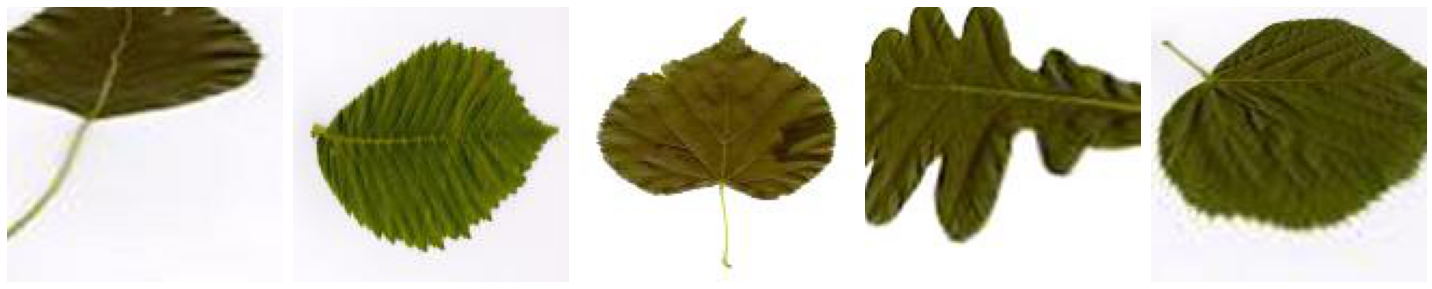

In [ ]:
#Plotting some Samples from the Train Set
plotImages(sample_training_images[:5])

Pre-Trained Model

In [ ]:
strategy=tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [ ]:
with strategy.scope():
  IMG_SHAPE=(128,128,3)
  base_model=tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
  base_model.trainable=False
  global_average_layer=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  hidden_layer=tf.keras.layers.Dense(128,activation='relu')(global_average_layer)
  d=tf.keras.layers.Dropout(0.2)(hidden_layer)
  prediction_layer=tf.keras.layers.Dense(15,kernel_regularizer=tf.keras.regularizers.l2(0.005),activation='softmax')(d)
  model=tf.keras.models.Model(inputs=base_model.input,outputs=prediction_layer)
  model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
history=model.fit(train_dataset,epochs=50,validation_data=val_dataset,verbose=1)

Epoch 1/50
75/75 [==============================] - 2685s 36s/step - loss: 3.0816 - accuracy: 0.0996 - val_loss: 2.7475 - val_accuracy: 0.1508
Epoch 2/50
75/75 [==============================] - 10s 130ms/step - loss: 2.6746 - accuracy: 0.1740 - val_loss: 2.4777 - val_accuracy: 0.2517
Epoch 3/50
75/75 [==============================] - 10s 130ms/step - loss: 2.4235 - accuracy: 0.2558 - val_loss: 2.2655 - val_accuracy: 0.3558
Epoch 4/50
75/75 [==============================] - 10s 131ms/step - loss: 2.2340 - accuracy: 0.3350 - val_loss: 2.0781 - val_accuracy: 0.4283
Epoch 5/50
75/75 [==============================] - 10s 130ms/step - loss: 2.0548 - accuracy: 0.4033 - val_loss: 1.9060 - val_accuracy: 0.5058
Epoch 6/50
75/75 [==============================] - 10s 132ms/step - loss: 1.9146 - accuracy: 0.4665 - val_loss: 1.7576 - val_accuracy: 0.5700
Epoch 7/50
75/75 [==============================] - 10s 135ms/step - loss: 1.7653 - accuracy: 0.5067 - val_loss: 1.6231 - val_accuracy: 0.6175

Fine Tuning the model by Unfreezing some deep layers of the pre-trained model so that our model can work on extracting the required low level features for the dataset rather than generalizing.

In [ ]:
base_model.trainable=True

In [ ]:
print('Number of layers in the base Model: ',len(base_model.layers))

Number of layers in the base Model:  155


In [ ]:
fine_tune_at=100

In [ ]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable=False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.00001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=val_dataset)

Plotting Training vs Validation Accuracy and Loss before Fine-Tuning

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

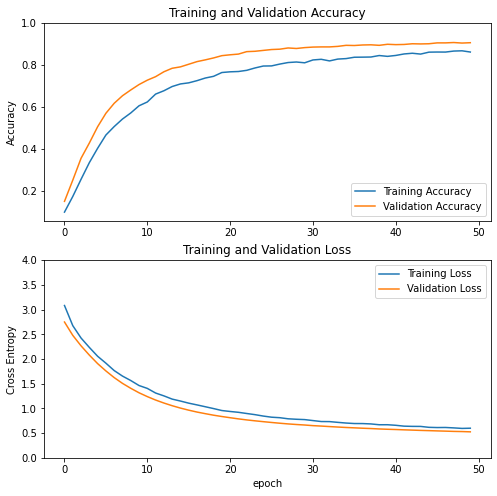

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Plotting Training vs Validation Accuracy and Loss after Fine-Tuning

[]

In [ ]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

KeyError: ignored

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 0.8])
plt.plot([10-1,10-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([1.1, 1.8])
plt.plot([10-1,10-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluating the Model on the Test Set

In [ ]:
test_loss,test_accuracy=model.evaluate_generator(test_dataset)

In [ ]:
print('Test Loss : ',test_loss)
print('Test_Accuracy: ',test_accuracy)

We got accuracy of 86% on Test Dataset

In [ ]:
#Saving the Model Architecture and weights
model.save('my_model.h5')

In [ ]:
model.save_weights('my_model_weights.h5')